# 1. Imports

In [1]:
import os
import torch
import clip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import cv2

from PIL import Image
from sklearn.model_selection import train_test_split

D:\Logiciels\Anaconda\envs\clip_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!python --version
print('\n'.join(f'{m.__name__} {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.9.18
torch 1.7.1
pandas 1.5.2
numpy 1.23.5
seaborn 0.12.2
cv2 4.11.0
PIL.Image 10.4.0


# 2. CLIP

## 2.1 Chargement des modèles de CLIP

In [3]:
def load_clip_model(model_name="ViT-B/32"):
    # Détection de l'utilisation du GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Affichage des modèles disponibles
    available_models = clip.available_models()
    print(f"Modèles disponibles : {available_models}")
    
    # Chargement du modèle et la fonction du prétraitement
    model, preprocess = clip.load(model_name, device=device)
    print(f"Modèle {model_name} chargé sur {device}")
    
    return model, preprocess, device

model, preprocess, device = load_clip_model()

Modèles disponibles : ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Modèle ViT-B/32 chargé sur cuda


## 2.2 Préparation des inputs

In [4]:
def prepare_clip_inputs(image_dir, dataset_path, preprocess, device):
    # Récupaération des noms des images 
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")]
    
    # Chargement et prétraitement des images
    image_inputs = []
    for filename in image_filenames:
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_inputs.append(image_input)
        
    # Concaténation des images dans un seul tenseur
    image_inputs = torch.cat(image_inputs, dim=0)
    
    # Chargement du dataset et récupération des catégories
    df = pd.read_csv(dataset_path, sep=";")
    categories = df['category_level_1'].unique().tolist()
    
    # Formatage des catégories pour adapter à CLIP
    text_prompts = [
        f"An image of a product in the {category} category" for category in categories
    ]
    
    # Tokeniser les catégories
    text_inputs = clip.tokenize(text_prompts).to(device)
    
    print(f"Images prétraitées et {len(categories)} catégories extraites du dataset")
    return image_inputs, text_inputs, categories, image_filenames

dataset_path = "data/df_images.csv"
image_dir = "images_exemple"
image_inputs, text_inputs, categories, image_filenames = prepare_clip_inputs(image_dir, dataset_path, preprocess, device)

Images prétraitées et 7 catégories extraites du dataset


## 2.3 Encodage des features

In [5]:
def encode_clip_features(model, image_inputs, text_inputs):
    with torch.no_grad():
        # Encodage des images
        image_features = model.encode_image(image_inputs)
        
        # Encodage des textes
        text_features = model.encode_text(text_inputs)
        
        # Noramlisation des features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
    print(f"Encodage terminé : {image_features.shape[0]} images et {text_features.shape[0]} catégories")
    return image_features, text_features

image_features, text_features = encode_clip_features(model, image_inputs, text_inputs)

Encodage terminé : 10 images et 7 catégories


## 2.4 Prédiction des catégories

In [6]:
def predict_clip_categories(image_features, text_features, categories, image_filenames, dataset_path):
    # Calcul des similitaires entre les images et les catégories
    similarity = (100.0 * image_features @ text_features.T)
    
    # Application du softmax pour obtenir les probabilités
    probs = similarity.softmax(dim=1).cpu().numpy()
    
    # Récupération de la meilleure catégorie pour chaque image
    predicted_indices = probs.argmax(axis=1)
    predicted_categories = [categories[i] for i in predicted_indices]
    
    # Chargement du dataset pour récupérer les vraies catégories
    df = pd.read_csv(dataset_path, sep=";")
    
    # Création d'un dictionnaire pour récupérer les catégories
    true_category_map = dict(zip(df["image"], df["category_level_1"]))
    
    true_categories = [true_category_map[img] for img in image_filenames]
    
    # Création d'un DataFrame pour afficher les résultats
    predictions_df = pd.DataFrame({
        "Image": image_filenames,
        "Vraie catégorie": true_categories,
        "Prédiction": predicted_categories,
    })
    
    print(f"Prédictions effectuées pour {len(image_filenames)} images")
    display(predictions_df)
    return predictions_df

predictions_df = predict_clip_categories(image_features, text_features, categories, image_filenames, dataset_path)

Prédictions effectuées pour 10 images


,Image,Vraie catégorie,Prédiction
0,00cbbc837d340fa163d11e169fbdb952.jpg,Home Furnishing,Home Furnishing
1,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care,Beauty and Personal Care
2,00e966a5049a262cfc72e6bbf68b80e7.jpg,Computers,Computers
3,00ed03657cedbe4663eff2d7fa702a33.jpg,Computers,Beauty and Personal Care
4,0a3b5fdf77a361c2d7d9b29c259b8c4e.jpg,Home Decor & Festive Needs,Baby Care
5,0a8a1e9c6659361c0c2b247f8a6471d0.jpg,Home Furnishing,Home Furnishing
6,0abfcbe0e17dd50c4cf5fb1d6037d514.jpg,Beauty and Personal Care,Beauty and Personal Care
7,0ae859a69c7608d8197c3ba8c37bc6ec.jpg,Home Decor & Festive Needs,Home Decor & Festive Needs
8,0b793c1727ef52285a25dedf8b86626b.jpg,Beauty and Personal Care,Beauty and Personal Care
9,0b8c4bc35aee94af356cb1fd2dfa0219.jpg,Kitchen & Dining,Kitchen & Dining


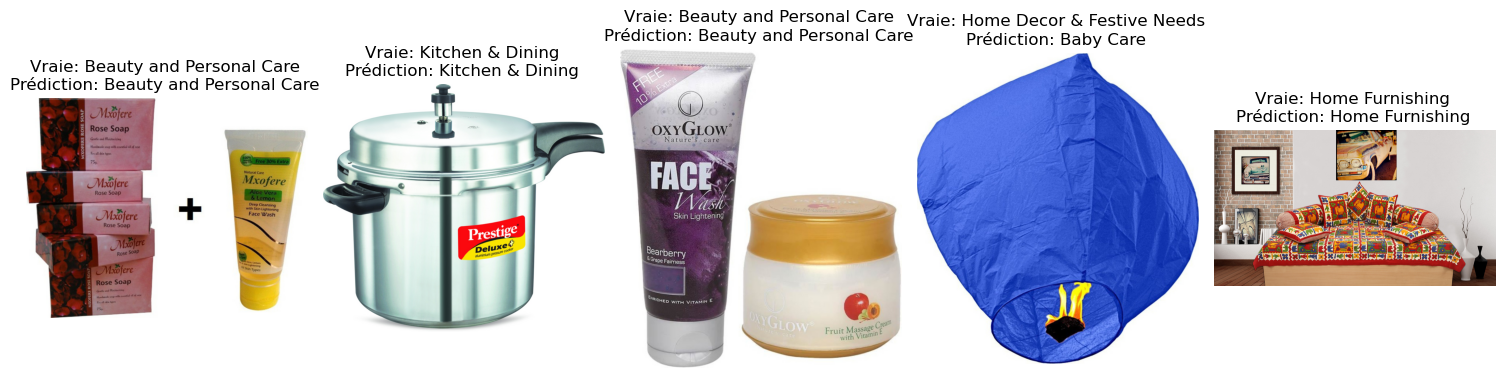

In [7]:
def display_predictions(image_dir, predictions_df, sample_size=5):
    # Sélection d'un échantillon aléatoire
    sample_df = predictions_df.sample(n=min(sample_size, len(predictions_df)))

    # Création du graphique
    fig, axes = plt.subplots(1, len(sample_df), figsize=(15, 5))

    for ax, (_, row) in zip(axes, sample_df.iterrows()):
        image_path = os.path.join(image_dir, row["Image"])
        image = Image.open(image_path)

        # Titre avec vraie catégorie et prédiction
        label = f"Vraie: {row['Vraie catégorie']}\nPrédiction: {row['Prédiction']}"

        # Affichage de l'image
        ax.imshow(image)
        ax.set_title(label, fontsize=12)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

display_predictions(image_dir="images_exemple", predictions_df=predictions_df, sample_size=5)

# 3. Comparaison

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 3.1 Préparation des données

In [9]:
df = pd.read_csv("data/df_images.csv", sep=";")

df_train, df_tmp = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["category_level_1"]
)

df_val, df_test = train_test_split(
    df_tmp, test_size=0.5, random_state=42, stratify=df_tmp["category_level_1"]
)

df_train["split"] = "train"
df_val["split"] = "val"
df_test["split"] = "test"

df_split = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)
df_split.to_csv("data/df_images_split.csv", sep=";", index=False)

## 3.2 Extraction des features

In [10]:
def extract_clip_features(image_dir, dataset_path, model, preprocess, device):
    df_split = pd.read_csv(dataset_path, sep=";")

    # Dictionnaire pour stocker les features et les labels
    features_dict = {
        "train": [],
        "val" : [],
        "test": []
    }

    labels_dict = {
        "train" : [],
        "val" : [],
        "test" : []
    }

    # Boucle sur chaque split
    for split in ["train", "val", "test"]:
        df_subset = df_split[df_split["split"] == split]
        image_filenames = df_subset["image"].tolist()
        categories = df_subset["category_level_1"].tolist()

        image_inputs = []
        for filename in image_filenames:
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            image_input = preprocess(image).unsqueeze(0).to(device)
            image_inputs.append(image_input)

        # Concaténer en un seul batch
        image_inputs = torch.cat(image_inputs, dim=0)

        # Extraire les features CLIP
        with torch.no_grad():
            image_features = model.encode_image(image_inputs)

        # Normaliser les features
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Stocker les features et labels
        features_dict[split] = image_features.cpu().numpy()
        labels_dict[split] = categories

        print(f"Features extraites pour {split} : {len(image_filenames)} images")

    return features_dict, labels_dict

# Exécution de l'extraction
features_dict, labels_dict = extract_clip_features(
    image_dir="images", 
    dataset_path="data/df_images_split.csv", 
    model=model, 
    preprocess=preprocess, 
    device=device
)

D:\Logiciels\Anaconda\envs\clip_env\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Features extraites pour train : 735 images
Features extraites pour val : 157 images
Features extraites pour test : 158 images


## 3.3 Création du modèle

In [11]:
def prepare_training_data(features_dict, labels_dict):
    # Récupérer les features et labels
    X_train, X_val, X_test = (
        np.array(features_dict["train"]),
        np.array(features_dict["val"]),
        np.array(features_dict["test"])
    )
    
    y_train, y_val, y_test = (
        np.array(labels_dict["train"]),
        np.array(labels_dict["val"]),
        np.array(labels_dict["test"])
    )
    
    # Encoder les labels
    label_encoder = LabelEncoder()
    y_train_encoder = to_categorical(label_encoder.fit_transform(y_train))
    y_val_encoder = to_categorical(label_encoder.fit_transform(y_val))
    y_test_encoder = to_categorical(label_encoder.fit_transform(y_test))
    
    # Définir le nombre de classes
    num_classes = y_train_encoder.shape[1]
    
    # Définir le modèle
    model_clip = Sequential([
        Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    
    # Compiler le modèle
    model_clip.compile(
        loss="categorical_crossentropy",
        optimizer="rmsprop",
        metrics=["accuracy"]
    )
    
    # Afficher le résumé du modèle
    model_clip.summary()
    return X_train, X_val, X_test, y_train_encoder, y_val_encoder, y_test_encoder, num_classes, model_clip

X_train, X_val, X_test, y_train_encoder, y_val_encoder, y_test_encoder, num_classes, model_clip = prepare_training_data(features_dict, labels_dict)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 133,127
Trainable params: 133,127
Non-trainable params: 0
_________________________________________________________________


## 3.4 Entraînement du modèle

In [12]:
def train_clip_model(model_clip, X_train, X_val, y_train_encoder, y_val_encoder):
    # Callbacks
    model_path = "./model_clip_best.weights.h1"
    checkpoint = ModelCheckpoint(model_path, monitor="val_loss", save_weights_only=True,
                                 verbose=1, save_best_only=True, mode="min")

    early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

    start_model_time = time.time()
    history = model_clip.fit(
        X_train, y_train_encoder,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val_encoder),
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    end_model_time = time.time()
    model_time = end_model_time - start_model_time
    print(f"Temps d'exécution : {model_time} secondes")
    return model_clip, model_time, model_path, history

model_clip, model_time, model_path, history_clip = train_clip_model(model_clip, X_train, X_val, y_train_encoder, y_val_encoder)

Epoch 1/50
 1/12 [=>............................] - ETA: 5s - loss: 1.9474 - accuracy: 0.0781
Epoch 1: val_loss improved from inf to 1.69403, saving model to .\model_clip_best.weights.h1
12/12 [==============================] - 1s 22ms/step - loss: 1.8431 - accuracy: 0.4830 - val_loss: 1.6940 - val_accuracy: 0.8280
Epoch 2/50
 1/12 [=>............................] - ETA: 0s - loss: 1.6973 - accuracy: 0.8281
Epoch 2: val_loss improved from 1.69403 to 1.42631, saving model to .\model_clip_best.weights.h1
12/12 [==============================] - 0s 6ms/step - loss: 1.5766 - accuracy: 0.8000 - val_loss: 1.4263 - val_accuracy: 0.8408
Epoch 3/50
 1/12 [=>............................] - ETA: 0s - loss: 1.4107 - accuracy: 0.8594
Epoch 3: val_loss improved from 1.42631 to 1.18168, saving model to .\model_clip_best.weights.h1
12/12 [==============================] - 0s 6ms/step - loss: 1.3154 - accuracy: 0.8313 - val_loss: 1.1817 - val_accuracy: 0.8599
Epoch 4/50
 1/12 [=>.......................

## 3.5 Résultats du modèle

In [13]:
model_clip.load_weights(model_path)
train_loss_clip, train_accuracy_clip = model_clip.evaluate(X_train, y_train_encoder, verbose=1)
val_loss_clip, val_accuracy_clip = model_clip.evaluate(X_val, y_val_encoder, verbose=1)
test_loss_clip, test_accuracy_clip = model_clip.evaluate(X_test, y_test_encoder, verbose=1)

5/5 [==============================] - 0s 1ms/step - loss: 0.2258 - accuracy: 0.9367


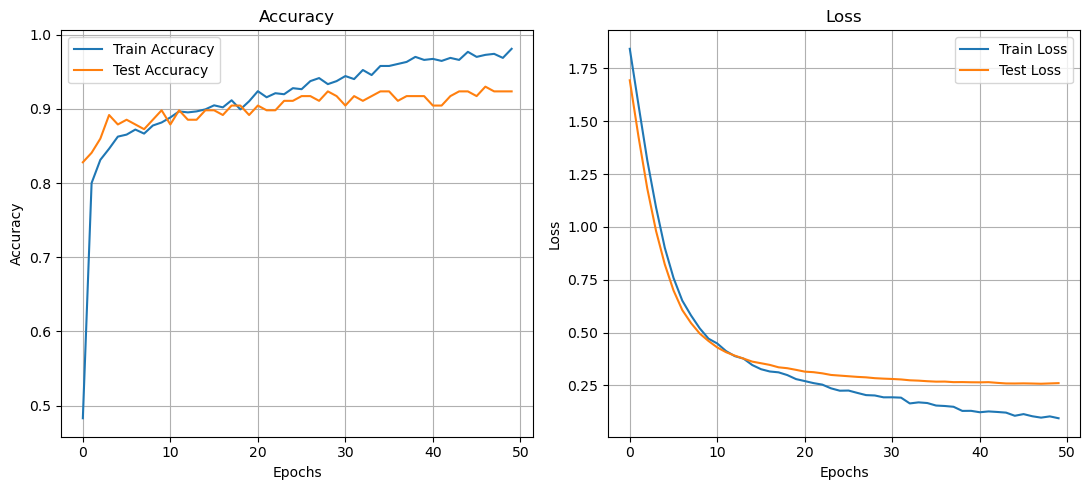

In [14]:
plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.plot(history_clip.history['accuracy'], label="Train Accuracy")
plt.plot(history_clip.history['val_accuracy'], label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(history_clip.history['loss'], label="Train Loss")
plt.plot(history_clip.history['val_loss'], label="Test Loss")  
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [15]:
results_df_clip = pd.DataFrame({
    'Model': ['CLIP (fine-tuning)'],

    'Train Accuracy': [train_accuracy_clip],
    'Validation Accuracy': [val_accuracy_clip],
    'Test Accuracy': [test_accuracy_clip],

    'Train Loss': [train_loss_clip],
    'Validation Loss': [val_loss_clip],
    'Test Loss': [test_loss_clip],

    'Temps d\'exécution (s)': [model_time], 
    'Epochs utilisées': [len(history_clip.epoch)]
})

results_df_clip.style.format({
    'Train Accuracy': '{:.2%}',
    'Validation Accuracy': '{:.2%}',
    'Test Accuracy': '{:.2%}',
    'Train Loss': '{:.4f}',
    'Validation Loss': '{:.4f}',
    'Test Loss': '{:.4f}',
    'Temps d\'exécution (s)': '{:.2f}'
}).set_caption('Résultats du modèle CLIP fine-tuné')

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Test Loss,Temps d'exécution (s),Epochs utilisées
0,CLIP (fine-tuning),98.50%,92.36%,93.67%,0.0792,0.2579,0.2258,4.05,50
